# ImageNet Classification with Deep Convolutional Neural Networks

## 1. Introduction


### Context

* ML machine methods of that time work well for relatvely small datasets. ( NORB, Caltech, Cifar )
* Until very recently larger datasets emerge like ImageNet, LabelMe
* Existing methods do not work well on these large datasets
* To learn about thousands of objects of millions of images a model with large learning capacity is needed.

### CNN's before this:
* CNN's have much fewer parameters so they are easier to train
* CNN's good performance for the number of parameters they have.
* Expensive to apply to large scale images, because there is no effective implementation.
* Highly optimized GPU implementation provided shown in the paper.

### How CNNs Work: Convolution and Backpropagation

**Convolutional Layers:**

* **Convolution operation:** Applies learnable filters (kernels) that slide across the input image
* **Key idea:** Instead of learning connections for every pixel position, CNNs use **weight sharing** - the same filter weights are applied at every spatial location
* **Benefits:**
    * **Translation invariance:** Can detect features regardless of their position in the image
    * **Parameter efficiency:** Far fewer parameters than fully-connected layers (e.g., a 5×5 filter has only 25 weights + bias, regardless of input size)
    * **Spatial structure:** Preserves spatial relationships between pixels

**Backpropagation in CNNs:**

* **Forward pass:** 
    * Input image → Convolution → Activation (ReLU) → Pooling → ... → Output
    * Each convolution computes: $y = \text{conv}(x, W) + b$ where $W$ are filter weights, $b$ is bias
    
* **Backward pass (gradient computation):**
    * **Gradient w.r.t. weights:** $\frac{\partial L}{\partial W} = \text{conv}(x, \frac{\partial L}{\partial y})$
        * This is what we need to **update the weights** during training
        * The gradient flows back through the same convolution operation
        * **Key insight:** Weight sharing means each weight's gradient is the **sum** of contributions from all spatial locations where that weight was applied
        * Example: A 5×5 filter has 25 weights. Each weight's gradient accumulates from all (H-4)×(W-4) positions where it was used
        * This makes backpropagation computationally efficient - we only compute gradients for 25 weights, not H×W separate weights per location

### Specific contributions:

* Achieved at that time best results on subsets of ImageNet used in the ILSVRC-2010 and ILSVRC-2012
* One of the largest conventional neural networks at that time.
* Highly optimized GPU implementation for CNNs.
* Number of new and unusual features of network which improve the result.
* Techniques to avoid overfitting.
* Final network consists of five convolutional and three fully connected layers.
* Fully utilized 2x Nvidia GTX 580 3GB GPUs

----

## 2. Dataset

### ImageNet Overview
* **Full dataset:** Over 15 million labeled high-resolution images in ~22,000 categories
* **Source:** Images collected from the web, labeled via Amazon Mechanical Turk
* **Competition:** ImageNet Large-Scale Visual Recognition Challenge (ILSVRC) started in 2010

### ILSVRC Dataset
* **Categories:** 1000 categories (1000 images each)
* **Split:**
    * ~1.2 million training images
    * 50,000 validation images
    * 150,000 test images
* **Evaluation metrics:**
    * **Top-1 error:** Fraction of test images where the correct label is not the most probable
    * **Top-5 error:** Fraction where correct label is not among the 5 most probable

### Image Preprocessing
* **Resizing:** Down-sampled to fixed 256×256 resolution
    * Rectangular images: shorter side rescaled to 256, then central 256×256 patch cropped
* **Normalization:** Subtracted mean activity over training set from each pixel
* **Input:** Network trained on (centered) raw RGB pixel values

## 3. The architecture

<img src="pinecone-image.png" alt="Architecture diagram" width="800">

Here are novel or unusual features of this netork described by the paper:

### ReLU Nonlinearity

<div style="overflow: auto;">
<img src="relu.png" alt="ReLU diagram" width="300" style="float: right; margin-top: 20px; margin-left: 20px; margin-bottom: 10px;">

* AlexNet popularized the use of ReLus for Deep CNNs
* Trains faster, which was demonstraded on CIFAR Dataset.
* Contrast with prior work:
    * Previous works used instead: $ f (x) = tanh(x)$ or $f (x) = (1 + e^{−x})^{−1}$, or $(x)=|tanh(x)|$
    * Focused on regularization instead of fitting large datasets

</div>

### Training on 2 GPUs

* GPUs had ~ 3gb memory which limits the size of networks
* The network was split into two gpus
* GPUs communicate only in certain layers, half parameters on each GPU.
* Faster to train than on one GPU
* Made use of NVIDIA CUDA framework

### Local Response Normalization

$$
b^{i}_{x,y} =
\frac{a^{i}_{x,y}}
{\left(
k + \alpha
\sum_{j=\max(0,\, i - \frac{n}{2})}^{\min(N - 1,\, i + \frac{n}{2})}
\left(a^{j}_{x,y}\right)^2
\right)^{\beta}}
$$

What each term means:
* $b^{i}_{x,y}$ activation after normalization
* $a^{i}_{x,y}$ feature map after convolution and ReLu
* $i$ feature map index
* $j$ neigbouring feature map index
* $x,y$ fixed pixel in the feature map
* $k$ Baseline numerical stabilizer
* $\sum_{j=\max(0,\, i - \frac{n}{2})}^{\min(N - 1,\, i + \frac{n}{2})}
\left(a^{j}_{x,y}\right)^2$ - Measures how strong nearby filters are at x,y
* $\alpha\beta $ Normalization strenth - scales the influence of neighbours, Beta controls the how much non linear the suppresion is.
----
* Batch Normalization is more effective
* LRN adds computational cost.
* Benefits do not scale to even deeper networks.

### Overlapping pooling

<img src="maxpooling.png" alt="ReLU diagram" width="300">

* summaraizes local neighborhoods within a feature map
* AlexNet used overlapping pooling window size 3*3, stride = 2
* Slightly harder to overfit
* Reduced error 0.4%

----

## 4. Reducing overfittting

* Even though dataset has 1000 classes, 60 million parameters of model make it easy to overfit.

### Data augmentation

* Easiest way reduce overfitting as described in paper.
* Augmentations:
    * Image translations and horizontal reflections. ( Random patches 224x224 from 256x256)
    * Color PCA for each pixel $I_{xy} = [R, G, B]^T$, add:
    
    $$ [p_1, p_2, p_3] \cdot [\alpha_1 \lambda_1, \alpha_2 \lambda_2, \alpha_3 \lambda_3]^T $$
    
    Where:
    * $p_i$ = $i$-th eigenvector of RGB covariance
    * $\lambda_i$ = $i$-th eigenvalue
    * $\alpha_i$ = Gaussian random variable, re-drawn per image
    
    **Why this works:**
    * Captures principal axes of variation in natural lighting/colors
    * Introduces realistic color shifts without changing object identity
    * Helps generalization for large-scale datasets like ImageNet

### Data Augmentation Demonstration

### Dropout

* Sets each hidden neuron to zero with probability 0.5 during training
* Reduces co-adaptations - forces learning of robust features
* Used in first two fully-connected layers
* Prevents substantial overfitting

----

## 5. Details of learning

* **Optimizer:** Stochastic gradient descent (batch size: 128, momentum: 0.9, weight decay: 0.0005)
    
    Update rule:
    $$v_{i+1} := 0.9 \cdot v_i - 0.0005 \cdot \epsilon \cdot w_i - \epsilon \cdot \left\langle \frac{\partial L}{\partial w}\Big|_{w_i} \right\rangle_{D_i}$$
    $$w_{i+1} := w_i + v_{i+1}$$
    
    Where:
    * $i$ = iteration index
    * $v_i$ = momentum variable (velocity)
    * $w_i$ = weights at iteration $i$
    * $\epsilon$ = learning rate
    * $0.9$ = momentum coefficient
    * $0.0005$ = weight decay coefficient
    * $\left\langle \frac{\partial L}{\partial w}\Big|_{w_i} \right\rangle_{D_i}$ = average gradient over batch $D_i$

* **Weight initialization:** Zero-mean Gaussian, std = 0.01
* **Bias initialization:**
    * Constant 1: Conv layers 2, 4, 5 and FC layers (helps ReLUs)
    * Constant 0: All other layers
* **Learning rate:** Started at 0.01, reduced by 10x when validation error plateaued
* **Training:** 90 epochs, 5-6 days on 2x NVIDIA GTX 580 GPUs

----

## 6. Results

### ILSVRC-2010
* **Top-1 error:** 37.5% (previous best: 47.1%)
* **Top-5 error:** 17.0% (previous best: 28.2%)

### ILSVRC-2012
* **Single CNN:** Top-5 error 18.2%
* **5 CNNs ensemble:** Top-5 error 16.4%
* **7 CNNs ensemble (with pre-training):** Top-5 error 15.3%
* **Previous best:** 26.2%

### ImageNet Fall 2009
* **Top-1 error:** 67.4% (previous best: 78.1%)
* **Top-5 error:** 40.9% (previous best: 60.9%)

### Qualitative Evaluations
* Learned kernels show frequency/orientation selectivity and colored blobs
* GPU specialization: GPU 1 kernels are color-agnostic, GPU 2 kernels are color-specific
* Network recognizes off-center objects
* Feature activations in last hidden layer capture semantic similarity (not just pixel-level similarity)



In [3]:
# Imports for data augmentation demonstration
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

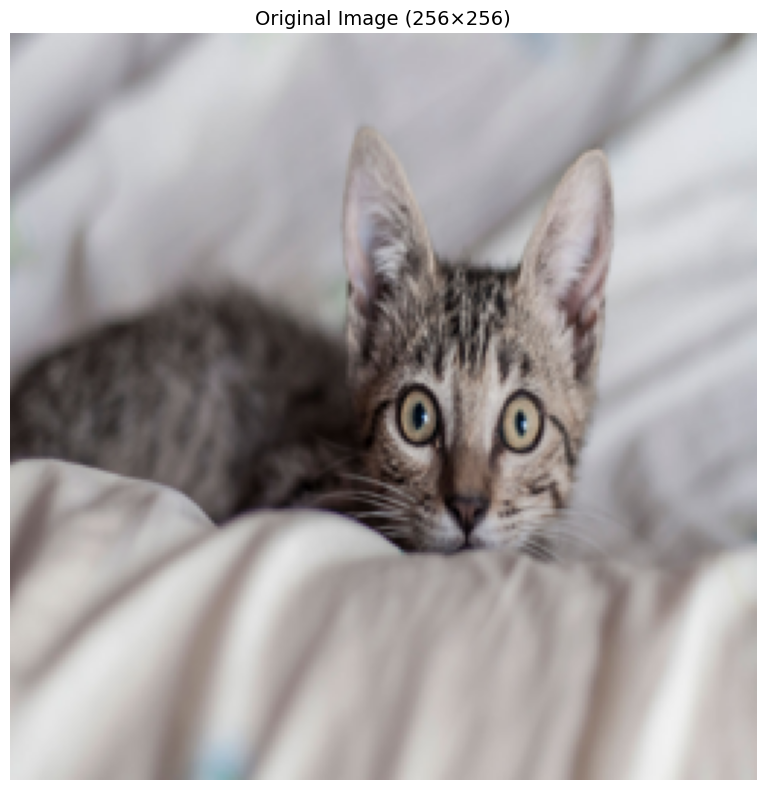

Original image size: (256, 256)


In [4]:
# Load or create a sample image (256x256 as per AlexNet preprocessing)
# Load cat.jpg image
img = Image.open('cat.jpg')
img = img.resize((256, 256))

# Display original image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title('Original Image (256×256)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Original image size: {img.size}")

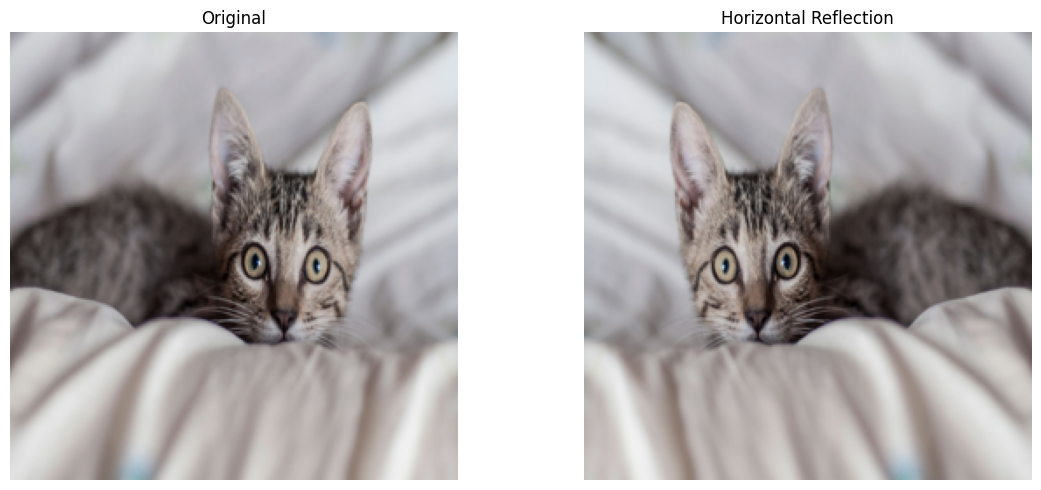

In [5]:
# 1. Horizontal Reflection (Mirror)
img_horizontal = img.transpose(Image.FLIP_LEFT_RIGHT)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original', fontsize=12)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_horizontal)
plt.title('Horizontal Reflection', fontsize=12)
plt.axis('off')

plt.tight_layout()
plt.show()

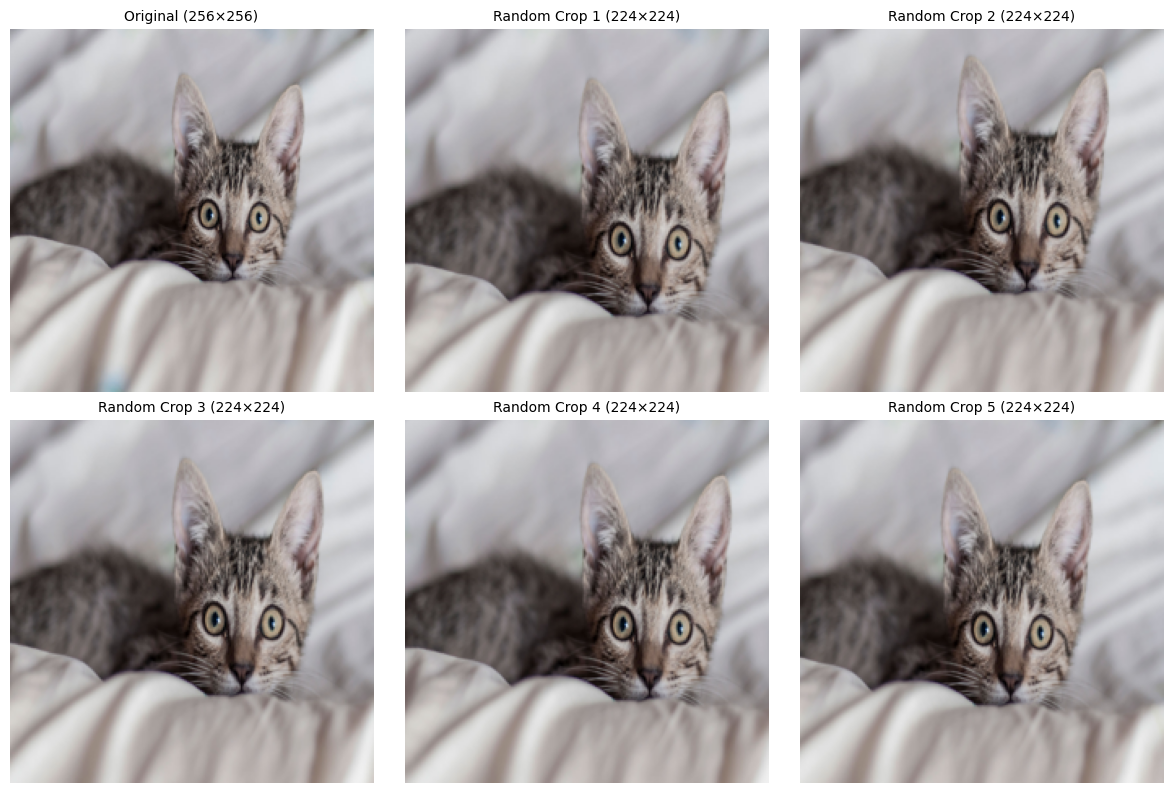

In [6]:
# 2. Random Crop (224×224 from 256×256)
# AlexNet uses random 224×224 patches from 256×256 images
# This simulates image translation

def random_crop(img, crop_size=224):
    """Extract random 224×224 patch from 256×256 image"""
    width, height = img.size
    # Calculate max top-left corner position
    max_x = width - crop_size
    max_y = height - crop_size
    # Random position
    x = random.randint(0, max_x)
    y = random.randint(0, max_y)
    # Crop
    return img.crop((x, y, x + crop_size, y + crop_size))

# Generate multiple random crops
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

axes[0].imshow(img)
axes[0].set_title('Original (256×256)', fontsize=10)
axes[0].axis('off')

# Show 5 different random crops
for i in range(1, 6):
    cropped = random_crop(img, crop_size=224)
    axes[i].imshow(cropped)
    axes[i].set_title(f'Random Crop {i} (224×224)', fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

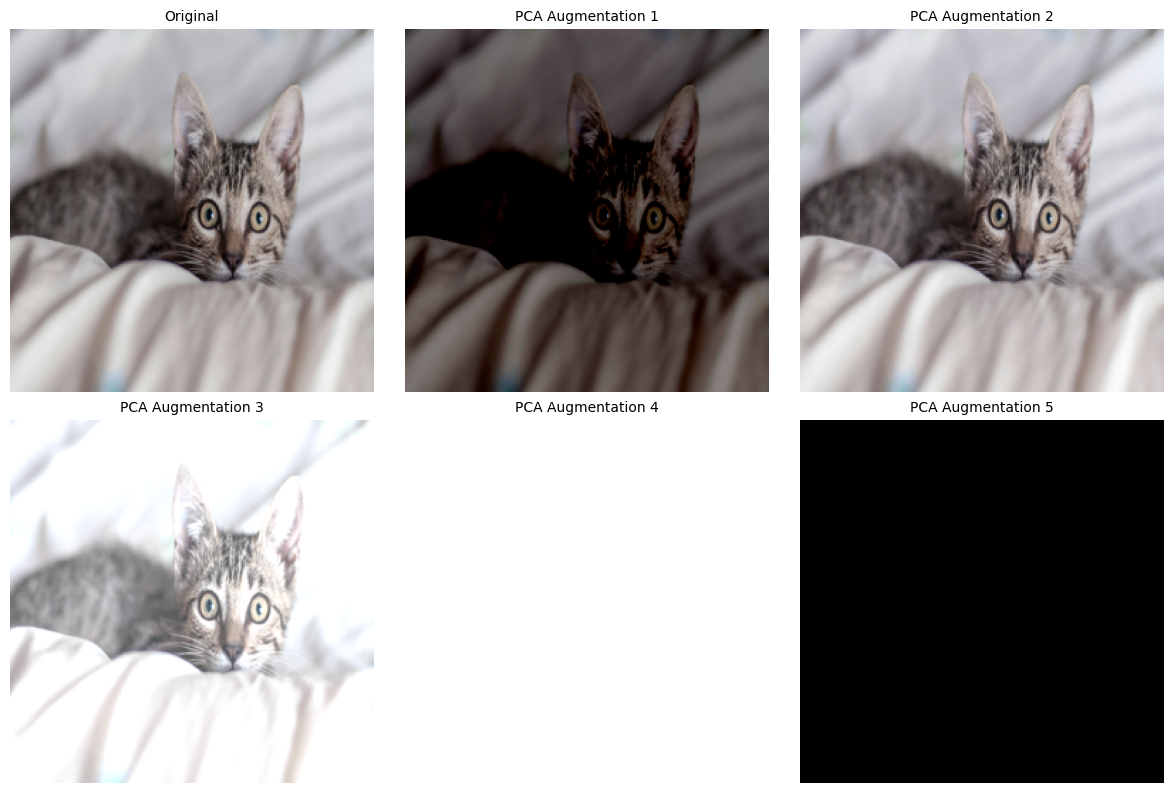

In [13]:
# 3. Color PCA Augmentation
# Adds color jittering based on principal components of RGB covariance

def color_pca_augmentation(img_array, alpha_std=0.1):
    """
    Apply PCA-based color augmentation as described in AlexNet paper.
    
    Args:
        img_array: numpy array of shape (H, W, 3) with RGB values
        alpha_std: standard deviation for Gaussian random variables
    """
    # Flatten image to (H*W, 3)
    pixels = img_array.reshape(-1, 3).astype(np.float32)
    
    # Compute RGB covariance matrix
    mean = pixels.mean(axis=0)
    pixels_centered = pixels - mean
    cov = np.cov(pixels_centered.T)
    
    # Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Sort in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Generate random alphas (Gaussian, re-drawn per image)
    alphas = np.random.normal(0, alpha_std, 3)
    
    # Compute color shift: [p1, p2, p3] · [α1λ1, α2λ2, α3λ3]^T
    shift = eigenvectors @ (alphas * eigenvalues)
    
    # Apply shift to all pixels
    augmented = pixels + shift
    augmented = np.clip(augmented, 0, 255).astype(np.uint8)
    
    return augmented.reshape(img_array.shape)

# Convert PIL image to numpy array
img_array = np.array(img)

# Apply PCA augmentation multiple times
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

axes[0].imshow(img)
axes[0].set_title('Original', fontsize=10)
axes[0].axis('off')

# Show 5 different PCA augmentations
for i in range(1, 6):
    augmented = color_pca_augmentation(img_array.copy(), alpha_std=0.1)
    axes[i].imshow(augmented)
    axes[i].set_title(f'PCA Augmentation {i}', fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

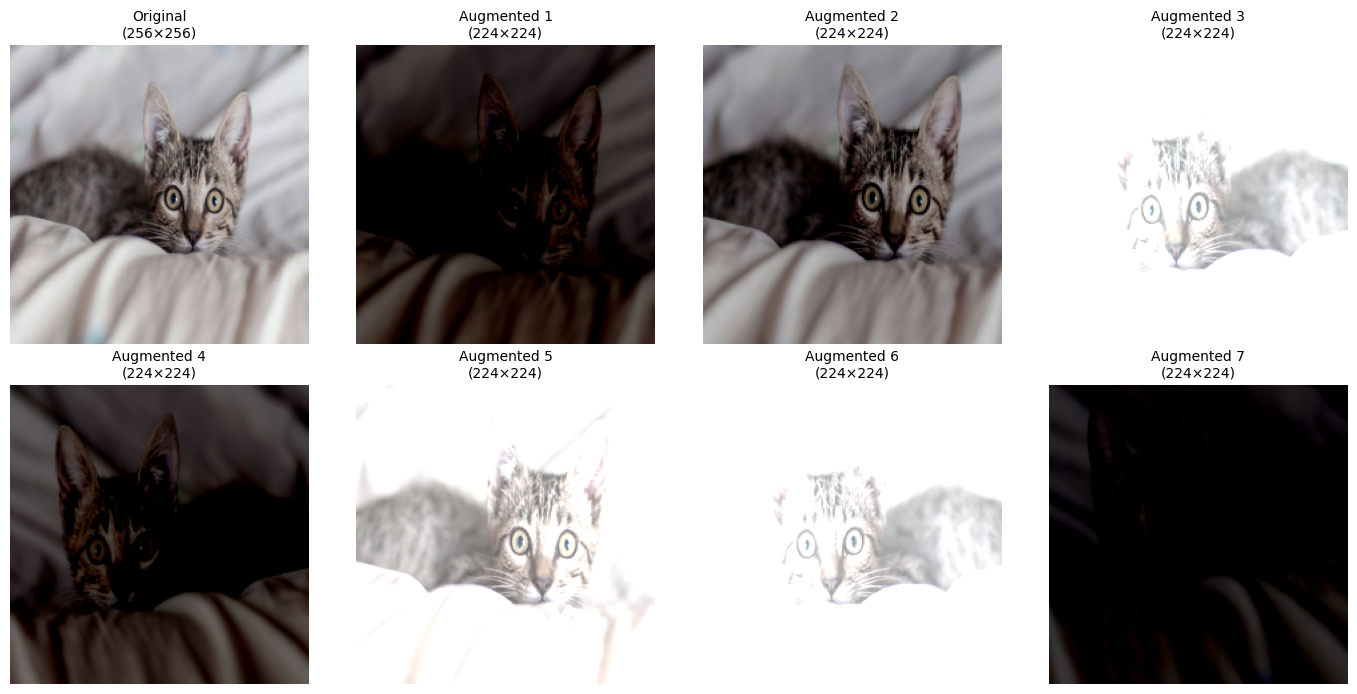

Note: Each augmentation randomly applies horizontal flip, random crop, and PCA color shift.


In [12]:
# Combined Augmentations: All techniques applied together
# This is what AlexNet uses during training

def alexnet_augment(img, apply_horizontal=True, apply_crop=True, apply_pca=True):
    """
    Apply all AlexNet data augmentations in sequence.
    """
    # 1. Random horizontal flip (50% probability)
    if apply_horizontal and random.random() > 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    
    # 2. Random crop to 224×224
    if apply_crop:
        img = random_crop(img, crop_size=224)
    else:
        # Center crop if not random
        width, height = img.size
        left = (width - 224) // 2
        top = (height - 224) // 2
        img = img.crop((left, top, left + 224, top + 224))
    
    # 3. Convert to array for PCA
    img_array = np.array(img)
    
    # 4. PCA color augmentation
    if apply_pca:
        img_array = color_pca_augmentation(img_array, alpha_std=0.1)
    
    return Image.fromarray(img_array)

# Show multiple augmented versions
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

axes[0].imshow(img)
axes[0].set_title('Original\n(256×256)', fontsize=10)
axes[0].axis('off')

# Show 7 different augmented versions
for i in range(1, 8):
    augmented = alexnet_augment(img.copy())
    axes[i].imshow(augmented)
    axes[i].set_title(f'Augmented {i}\n(224×224)', fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print("Note: Each augmentation randomly applies horizontal flip, random crop, and PCA color shift.")

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, (11, 11), (4, 4), (2, 2)),
            nn.ReLU(True),
            nn.MaxPool2d((3, 3), (2, 2)),

            nn.Conv2d(64, 192, (5, 5), (1, 1), (2, 2)),
            nn.ReLU(True),
            nn.MaxPool2d((3, 3), (2, 2)),

            nn.Conv2d(192, 384, (3, 3), (1, 1), (1, 1)),
            nn.ReLU(True),
            nn.Conv2d(384, 256, (3, 3), (1, 1), (1, 1)),
            nn.ReLU(True),
            nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
            nn.ReLU(True),
            nn.MaxPool2d((3, 3), (2, 2)),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)s

    # Support torch.script function
    def _forward_impl(self, x: Tensor) -> Tensor:
        out = self.features(x)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)

        return out

*